# Project 1 : Inverted Pendulum

### Shanmukha Chaitanya Peddeti       ASU id: 1228632836

# Documentation:

<img src="/1.jpg" width="" align="" />

<img src="/2.jpg" width="" align="" />

<img src="/3.jpg" width="" align="" />

<img src="/4.jpg" width="" align="" />

In [2]:
# Code updated from former student: https://github.com/siddahant/DESOPT/blob/RocketLanding/Rocket_Landing_Optimization.ipynb

# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Parameter
BOOST_ACCEL = 65 # thrust constant
FRAME_TIME = 0.01  # time interval
m = 1 # mass of the pendulum
M = 5 # mass of the cart
l = 0.6 # lenth of the pendulum
g = 9.81 # accleration due to gravity


In [4]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        
        state[0] = x       Displacement of the cart
        state[1] = vx      Velocity of the cart
        state[2] = theta   Angle of the pendulum w.r.t vertical
        state[3] = vtheta  Angular velocity of the pendulum
      
        """ 
        s = torch.sin(state[0,2])
        c = torch.cos(state[0,2])
        deno = M + m*(s**2)

        # delta1 is second order PDE due to effect of dynamics
        delta1 = m*l*(state[0,3]**2)*(1/deno)*torch.tensor([[0., s, 0., -s*c*(1/l)]]) 
        
        # delta1 is second order PDE due to effect of gravity
        delta2 = g*(1/deno) * torch.tensor([0., m*s*c, 0., -(m+M)*s*(1/l)]) 
        
        # delta1 is second order PDE due to effect of action
        # delta3 = (torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        delta3 = BOOST_ACCEL *(torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0.],
                                 [0., 1., 0., 0.],
                                 [0., 0., 1., FRAME_TIME],
                                 [0., 0., 0., 1.],])

        state = (step_mat @ state.T) + FRAME_TIME*(delta1.T + delta2.T + delta3.T) 
        state = state.T
        
        return state


In [5]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states = 4
        dim_output: # of actions = 1
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0.])) # controlling accleration of cart
        return action
     

In [13]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[0.,0.5,-1.,0.]] # initial positions
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):

        if (state[0,2] %(2*np.pi)) >= 6.26573 or (state[0,2] %(2*np.pi)) <= 0.0174533 :
            return 0
            
        # The error is a minimizing function of Velocit of the cart,Angle and Angular velocity of the pendulum 
        return  ((state[0,1]**2) +(state[0,2]**2) +(state[0,3]**2) / 3)
        

In [11]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        vx = data[:, 1]
        theta = data[:, 2]%(2*torch.pi)
        vtheta = data[:, 3]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        force = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (20, 10))

        ax[0,0].plot(frame, x, c = 'b', label = "X")
        ax[0,0].set_xlabel("Time Interval")
        ax[0,0].set_ylabel("x (m)")
        ax[0,0].set(title=f'Displacement of the cart at frame {self.epoch}')

        ax[0,1].plot(frame, vx, c = 'c', label = "Vx")
        ax[0,1].set_xlabel("Time Interval")
        ax[0,1].set_ylabel("Vx (m/s)")
        ax[0,1].legend(frameon=0)
        ax[0,1].set(title =f'Velocity of the cart at frame {self.epoch}')

        ax[1,0].plot(frame, theta, c = 'g', label = "Theta")
        ax[1,0].set_xlabel("Time Interval")
        ax[1,0].set_ylabel("Theta (rad)")
        ax[1,0].legend(frameon=0)
        ax[1,0].set(title=f'Angle of the pendulum at {self.epoch}')

        ax[1,1].plot(frame, vtheta, c = 'g', label = "V_theta")
        ax[1,1].set_xlabel("Time Interval")
        ax[1,1].set_ylabel("Angular velocity (rad/s)")
        ax[1,1].legend(frameon=0)
        ax[1,1].set(title=f'Angular velocity of the pendulum at {self.epoch}')

        ax[1,2].plot(frame, force, c = 'y', label = "Force")
        ax[1,2].set_xlabel("Time Interval")
        ax[1,2].set_ylabel("Force (N)")
        ax[1,2].legend(frameon=0)
        ax[1,2].set(title=f'Force on the cart at {self.epoch}')

        plt.show()

        # print('Displacement:', x)
        # print('Velocity:', vx)
        for i in range(len(theta)):
            print('Angle:', math.degrees(theta[i]) ,theta[i])
        # print('Angular Velocity:', vtheta)
        # print('Force:', force)

    def animation(self, epochs):

        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,10), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=-0.5, color='black', linestyle='--', lw=1)

        rod_fig, = ax1.plot([], [], linewidth = 4.5, color = 'black') # pendulum rod 
        pend_fig,= ax1.plot([], [], 'o', color = 'red', markersize = 12) # pendulum mass
        cart_fig,= ax1.plot([], [], 's', color = 'skyblue', markersize=20) # cart body
        force_fig,= ax1.plot([], [], linewidth = 6.5, color = 'green') # force line


        plt.tight_layout()

        ax1.set_xlim(-1,5 )
        ax1.set_ylim(-2, 3)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):

            x_1 = x_t[i,0]
            vx_1 = x_t[i,1]
            theta = x_t[i,2]
            vtheta_1 = x_t[i,3]

            cart_x = x_1 #+ vx_1 * FRAME_TIME
            pendulum_x =  cart_x + (l * math.sin(theta))
            pendulum_y = l * math.cos(theta)
        
            rod_fig.set_data([cart_x, pendulum_x], [0, pendulum_y])
            pend_fig.set_data(pendulum_x, pendulum_y)
            cart_fig.set_data(cart_x,0)

            force_1 = u_t[:i, 0]
            force_fig.set_data(cart_x+force_1 -0.5,0)

            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("inverted pendulum_.gif", writer=writer)
        

[1] loss: 18.829


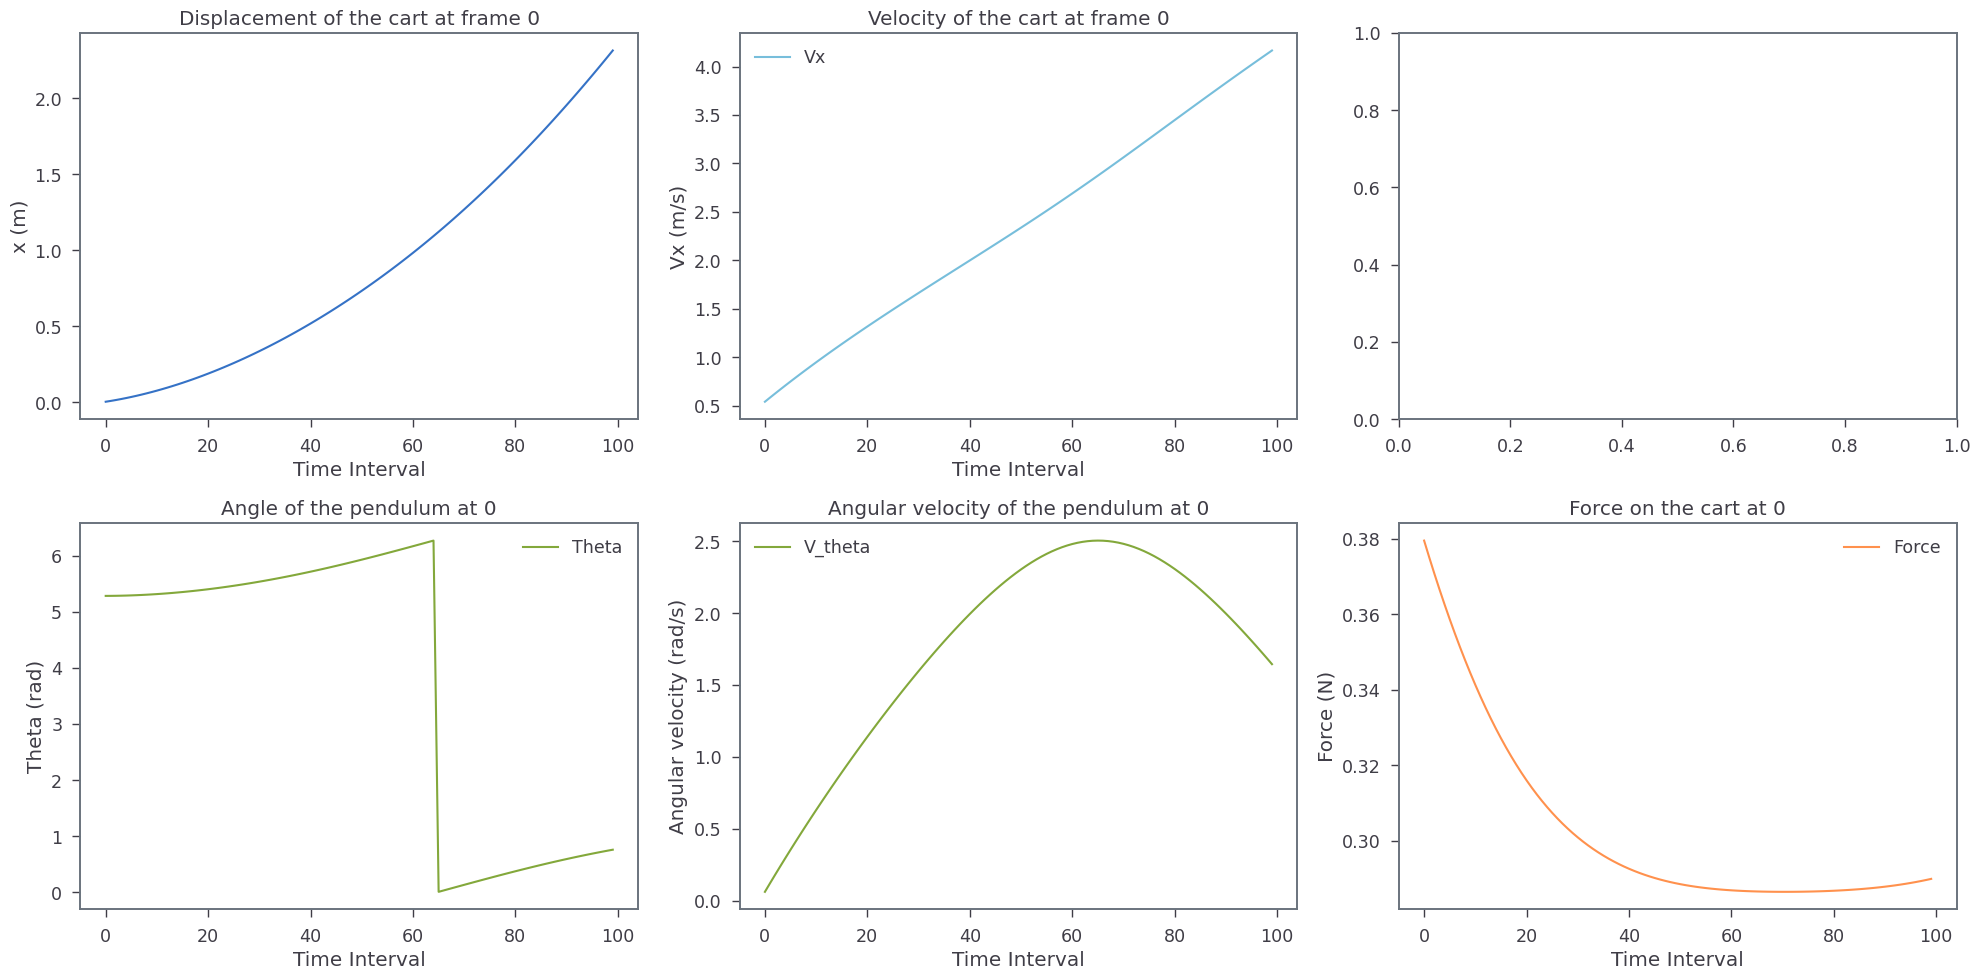

Angle: 302.7042305048303 5.2831855
Angle: 302.7389551865707 5.2837915
Angle: 302.80799473870115 5.2849965
Angle: 302.9109666706283 5.2867937
Angle: 303.0474611710018 5.289176
Angle: 303.21709574922824 5.2921367
Angle: 303.41948791471407 5.295669
Angle: 303.65428249762243 5.299767
Angle: 303.9211243281165 5.3044243
Angle: 304.21960359484603 5.3096337
Angle: 304.54941976948766 5.31539
Angle: 304.9102176822044 5.321687
Angle: 305.3016421631595 5.328519
Angle: 305.72336536327276 5.3358793
Angle: 306.17508675422073 5.3437634
Angle: 306.6564511661665 5.3521647
Angle: 307.16715807078674 5.3610783
Angle: 307.70693426051446 5.370499
Angle: 308.275424565513 5.380421
Angle: 308.87232845745876 5.390839
Angle: 309.4974000495416 5.4017487
Angle: 310.1502841719248 5.4131436
Angle: 310.83070761704147 5.4250193
Angle: 311.53839717732484 5.437371
Angle: 312.2730250036947 5.4501925
Angle: 313.0343178885843 5.4634795
Angle: 313.82197530367023 5.4772267
Angle: 314.6356693998722 5.4914284
Angle: 315.4751542

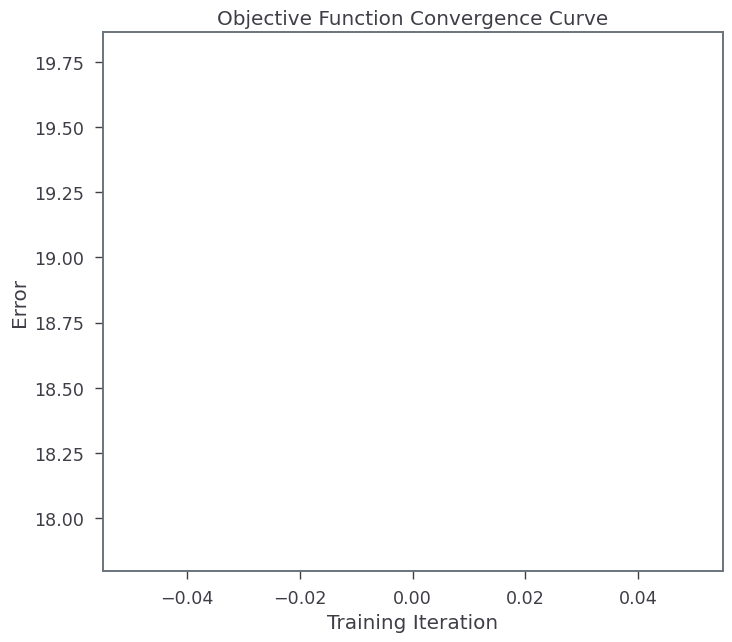

Generating Animation


IntProgress(value=0, max=101)

(100, 4) (100, 1)
/tmp/ipykernel_77/3899675743.py:142: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pend_fig.set_data(pendulum_x, pendulum_y)
/tmp/ipykernel_77/3899675743.py:143: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cart_fig.set_data(cart_x,0)
/tmp/ipykernel_77/3899675743.py:146: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  force_fig.set_data(cart_x+force_1 -0.5,0)


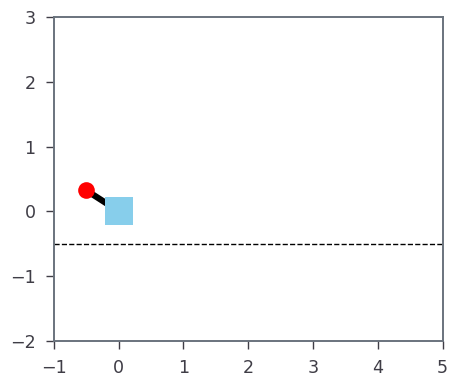

In [14]:
T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(1)  # training with number of epochs (gradient descent steps)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7c2bc5a-8560-49b0-9204-5d9e2bfeb73a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>